# 2D SUMMA plots

This notebook will show you how to make plots with the 2D variables in SUMMA. For example, plots that show how temperature evolves in the soil and snow pack or how total, liquid, and frozen moisture evolves. The plotting functions have been put together by Andrew Bennett.

Note that some of these plots take a while to generate, so we are selecting here for a single year before we plot. The plotting may also take a long time if you have many snow layers, but the plots look very pretty in that case. 

As before: Make use of the notebooks abilities to document what you are doing, so add text and comments as needed.

## Import modules and set some default settings

I typically start my notebook with an import of all the modules that I will be using anyway. I also use the same aliases every time, to make it easier to follow what I am doing:

In [1]:
%matplotlib inline
#import pysumma as ps # we don't need pysumma here, but you could also just leave it
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pysumma as ps
import xarray as xr
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better
import pandas as pd # an excellent time series package that we'll use to write some csv files


Note that in the list above there are a number of modules you did not have to import before, so make sure you include all of them.

In [2]:
sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.dpi'] = 200
mpl.style.use('ggplot')
sns.set_context('talk')


## 2D plots

The following two cells contain helper functions that create the plots. The first one (`justify()`) is not a function you need to call directly (it is used by the `plot_layers()` function).

In [3]:
def justify(a, invalid_val=np.nan, axis=1, side='right'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val) 
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

This is the function you would call (after some prep of your data). You can find different colormaps for matplotlib here: https://matplotlib.org/examples/color/colormaps_reference.html. If you want to invert a colormap, just add `_r`, so `'RdBu_r'` for example to get a colormap from blue to red.

In [4]:
def plot_layers(var, depth, ax=None, cbar_label=None, colormap='viridis'):
    # Preprocess the data
    vmask = (var != -9999)
    dmask = (depth != -9999)

    #    vmask = ((var != -9999) & (~np.isnan(var)))
    #    dmask = ((depth != -9999) & (~np.isnan(depth)))
    depth.values = justify(depth.where(dmask).values)
    var.values = justify(var.where(vmask).values)
    lo_depth = depth.where(depth > 0).T
    hi_depth = depth.where(depth < 0).T
    var = var.T
    time = depth.time.values
    
    # Map colors to full range of data
    norm = plt.Normalize(np.nanmin(var), np.nanmax(var))
    cmap = mpl.cm.get_cmap(colormap)
    rgba = cmap(norm(var))
    
    # Create axes if needed
    if not ax:
        fig, ax = plt.subplots(figsize=(18,8))
   
    # Plot soil layers - need to reverse because we plot bottom down
    for l in lo_depth.ifcToto.values[:-1][::-1]:
        y = lo_depth[l]
        y[np.isnan(y)] = 0
        ax.vlines(time, ymin=-y, ymax=0, color=rgba[l])
       
    # Plot snow layers - plot top down
    for l in hi_depth.ifcToto.values[:-1]:
        y = hi_depth[l]
        y[np.isnan(y)] = 0
        ax.vlines(time, ymin=0, ymax=-y, color=rgba[l])
        
    # Add the colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(var.values.flatten())
    label = None
    if cbar_label:
        label = cbar_label
    elif var.long_name and var.units:
        label = '{} ({})'.format(var.long_name, var.units)
    if label:
        plt.gcf().colorbar(mappable, label=label, ax=ax)
    return ax

## SUMMA Simulation

We'll use the PLUMBER Harvard site to do the simulation, so make sure you install it if you want to run the functions in this notebook. Of course you can try this on your own site as well. 


In [5]:
filemanager_path = '/home/jovyan/PLUMBER_data/sites/Harvard/settings/summa_zFileManager_Harvard.txt'
S = ps.Simulation(executable='summa.exe', filemanager=filemanager_path)

One of the variables we want to plot is the snow depth (not strictly necessary, but it looks good), so we need to make sure this is in the output control file. We can check the variables in the output control file :

In [6]:
print(S.output_control)

nSnow                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
nSoil                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
pptrate                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
airtemp                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarRainPlusMelt                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSWE                            | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallSnow                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallRain                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowSublimation                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarExfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceRunoff                  | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceTemp                    | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSenHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarLatHeatTotal                

If `scalarSnowDepth` is not in that list, you can add it

In [7]:
S.output_control.set_option(name='scalarSnowDepth',period=1)

scalarSnowDepth                      | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0


Note that there are many, many more variables you can potentially output. A complete list can be found in the SUMMA source code, here: https://github.com/bartnijssen/summa/blob/sopron_2018/build/source/dshare/var_lookup.f90#L332-L536

Run the simulation:

In [8]:
S.start(run_option='local', run_suffix='test')
S.monitor()

False

## 2D plot of soil temperature with time

Let's make a plot of the soil temperature with time. We'll select one year (water year 2001). The layer information we need is stored in `iLayerHeight` (the height of the interfaces between the layers) and the variable is `mLayerTemp` (the temperature that is representative for each layer). Note that we need to get rid of the `hru` dimension, so we just select `hru=1`.

In [9]:
start = '2000-10-01'
end = '2001-09-30'
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerTemp

Now we can use the `plot_layers()` function to create the 2D plot:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/srv/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


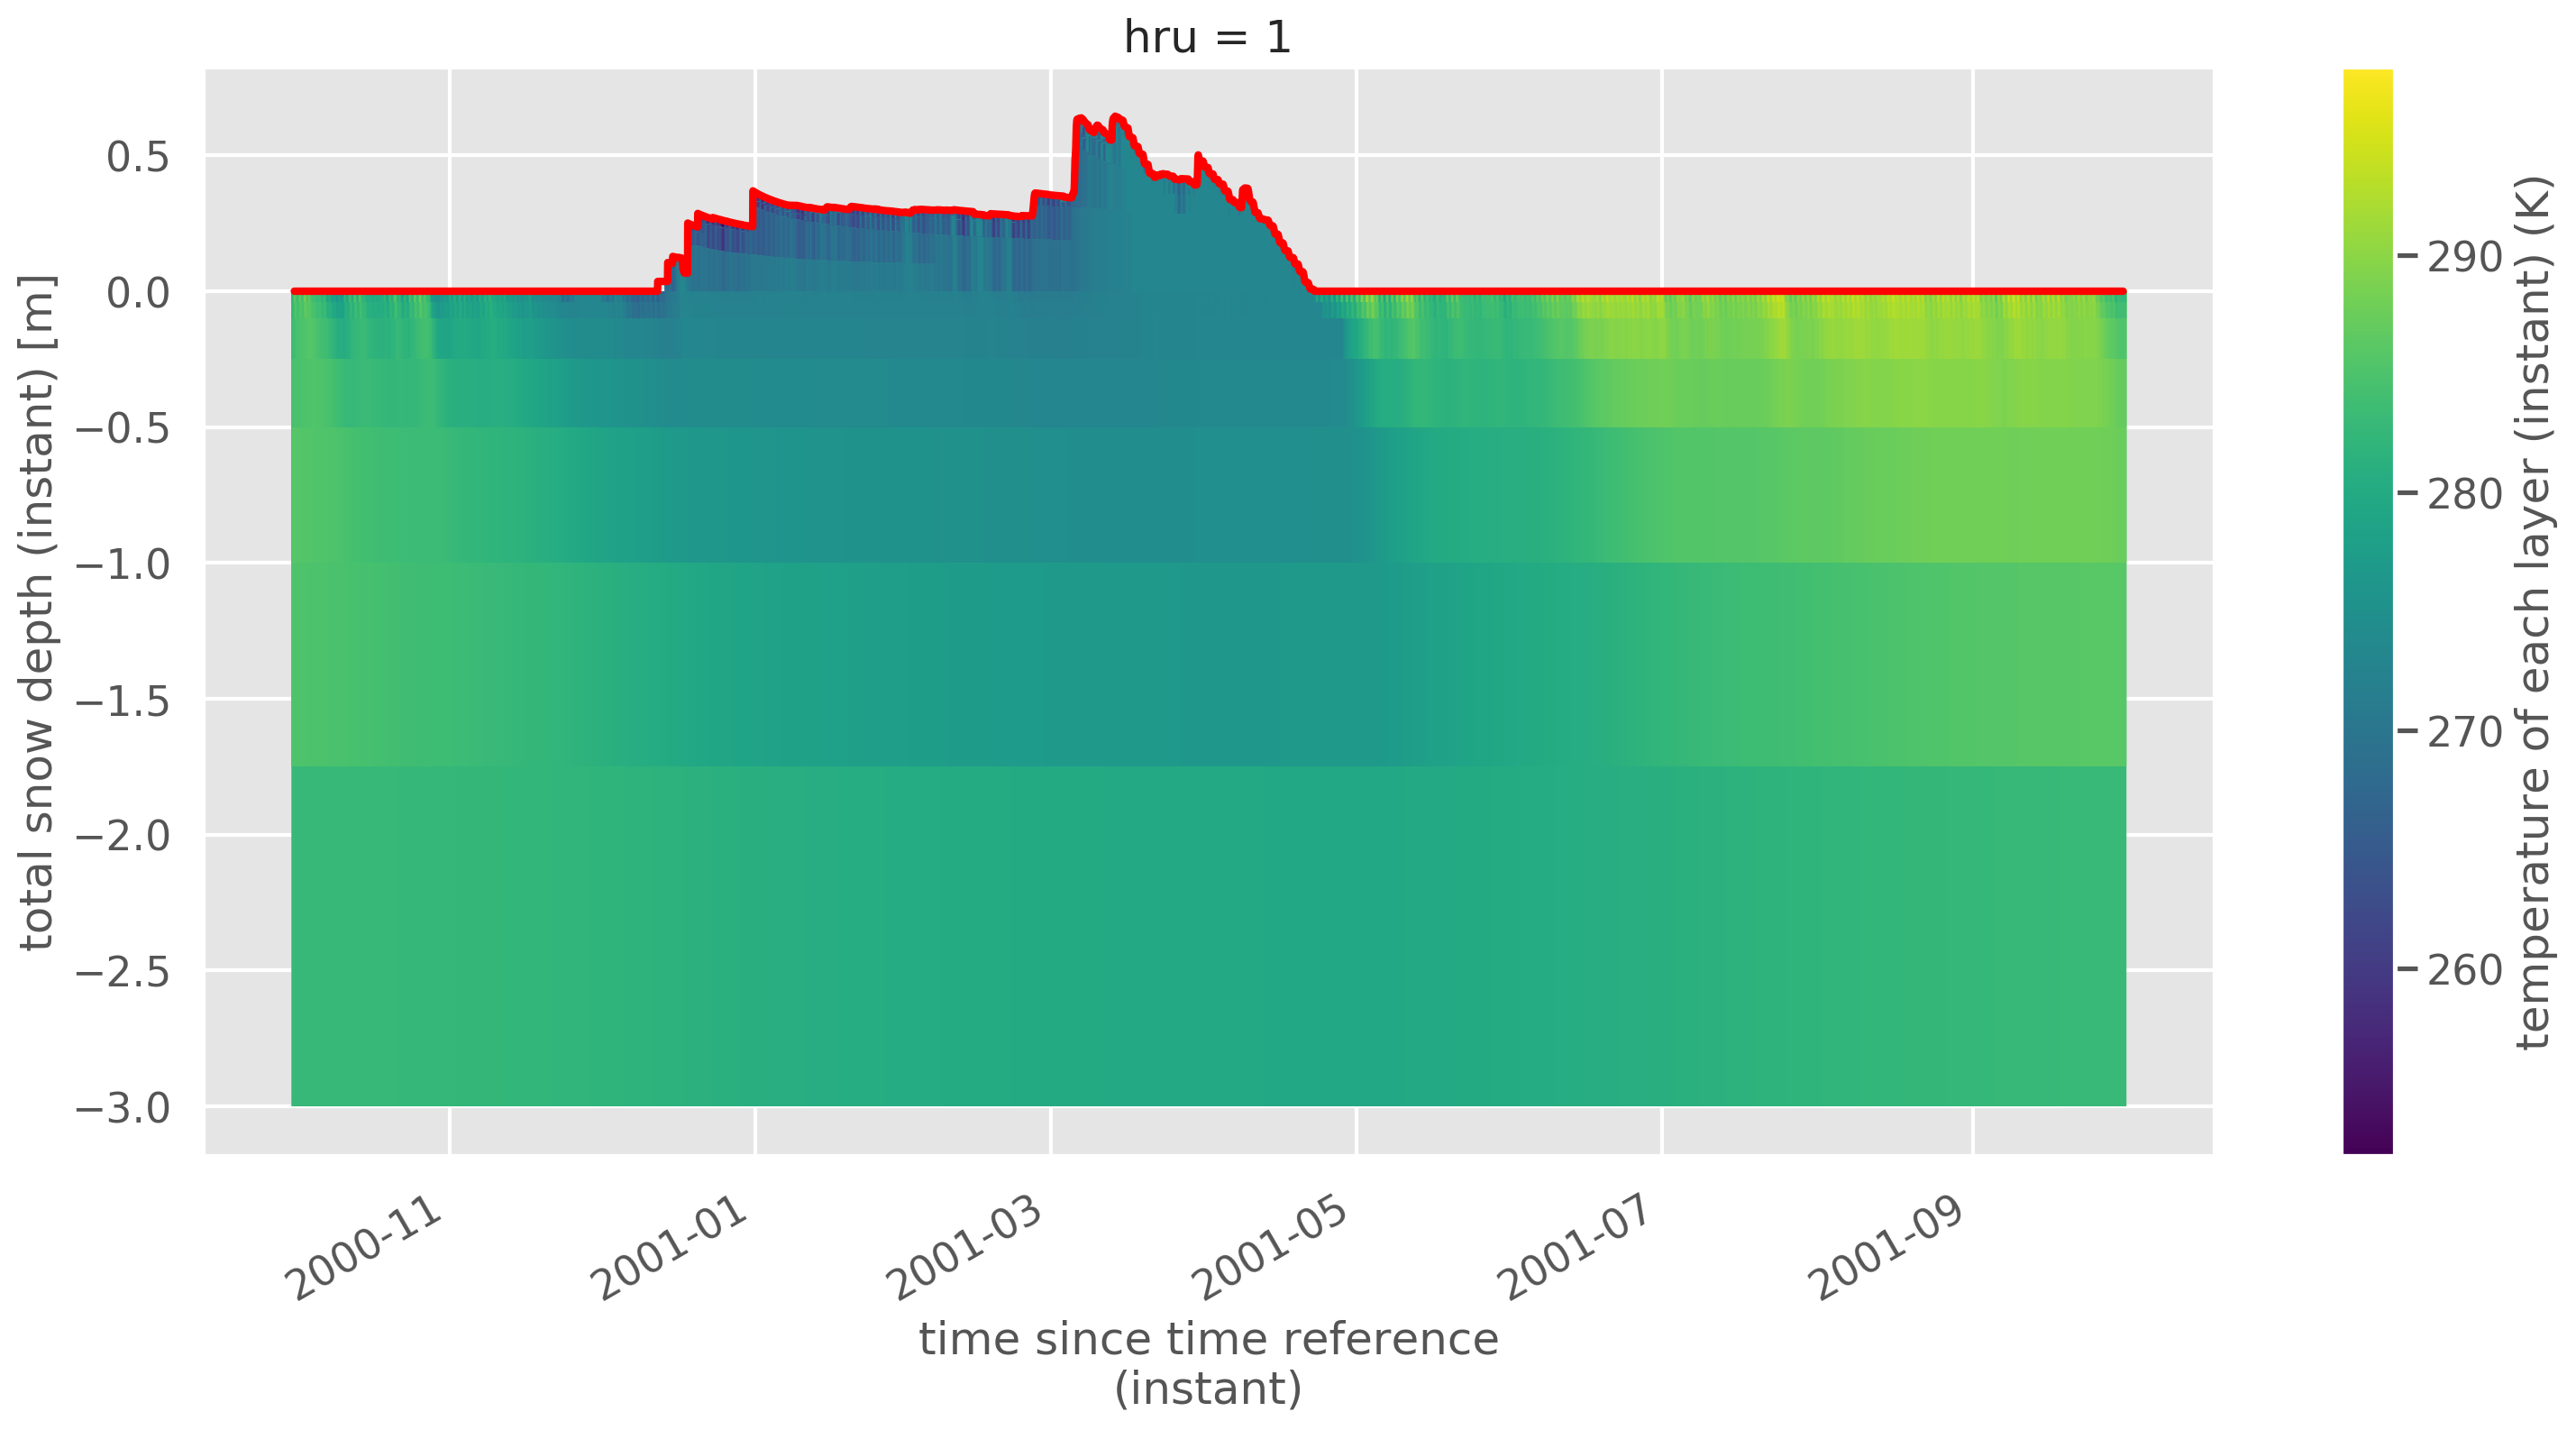

In [10]:
ax = plot_layers(var, depth)
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

It may be more interesting to plot this in ºC. We need to do a bit of extra work to make this come out right. We need to convert `var` from K to C, but then the plotting functions expect that the resulting data structure has some additional attributes (`long_name` and `units`), so we'll take care of those as well. In the current version of SUMMA output, the missing value is not set correctly, so we need to preserve the `-9999.`:

In [11]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
temp_var = S.output.sel(time=slice(start, end), hru=1).mLayerTemp
var = temp_var.where(temp_var>-9999.) - 273.16
var.attrs['long_name'] = temp_var.attrs['long_name']
var.attrs['units'] = 'C'

Then we'll also use a different color bar:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


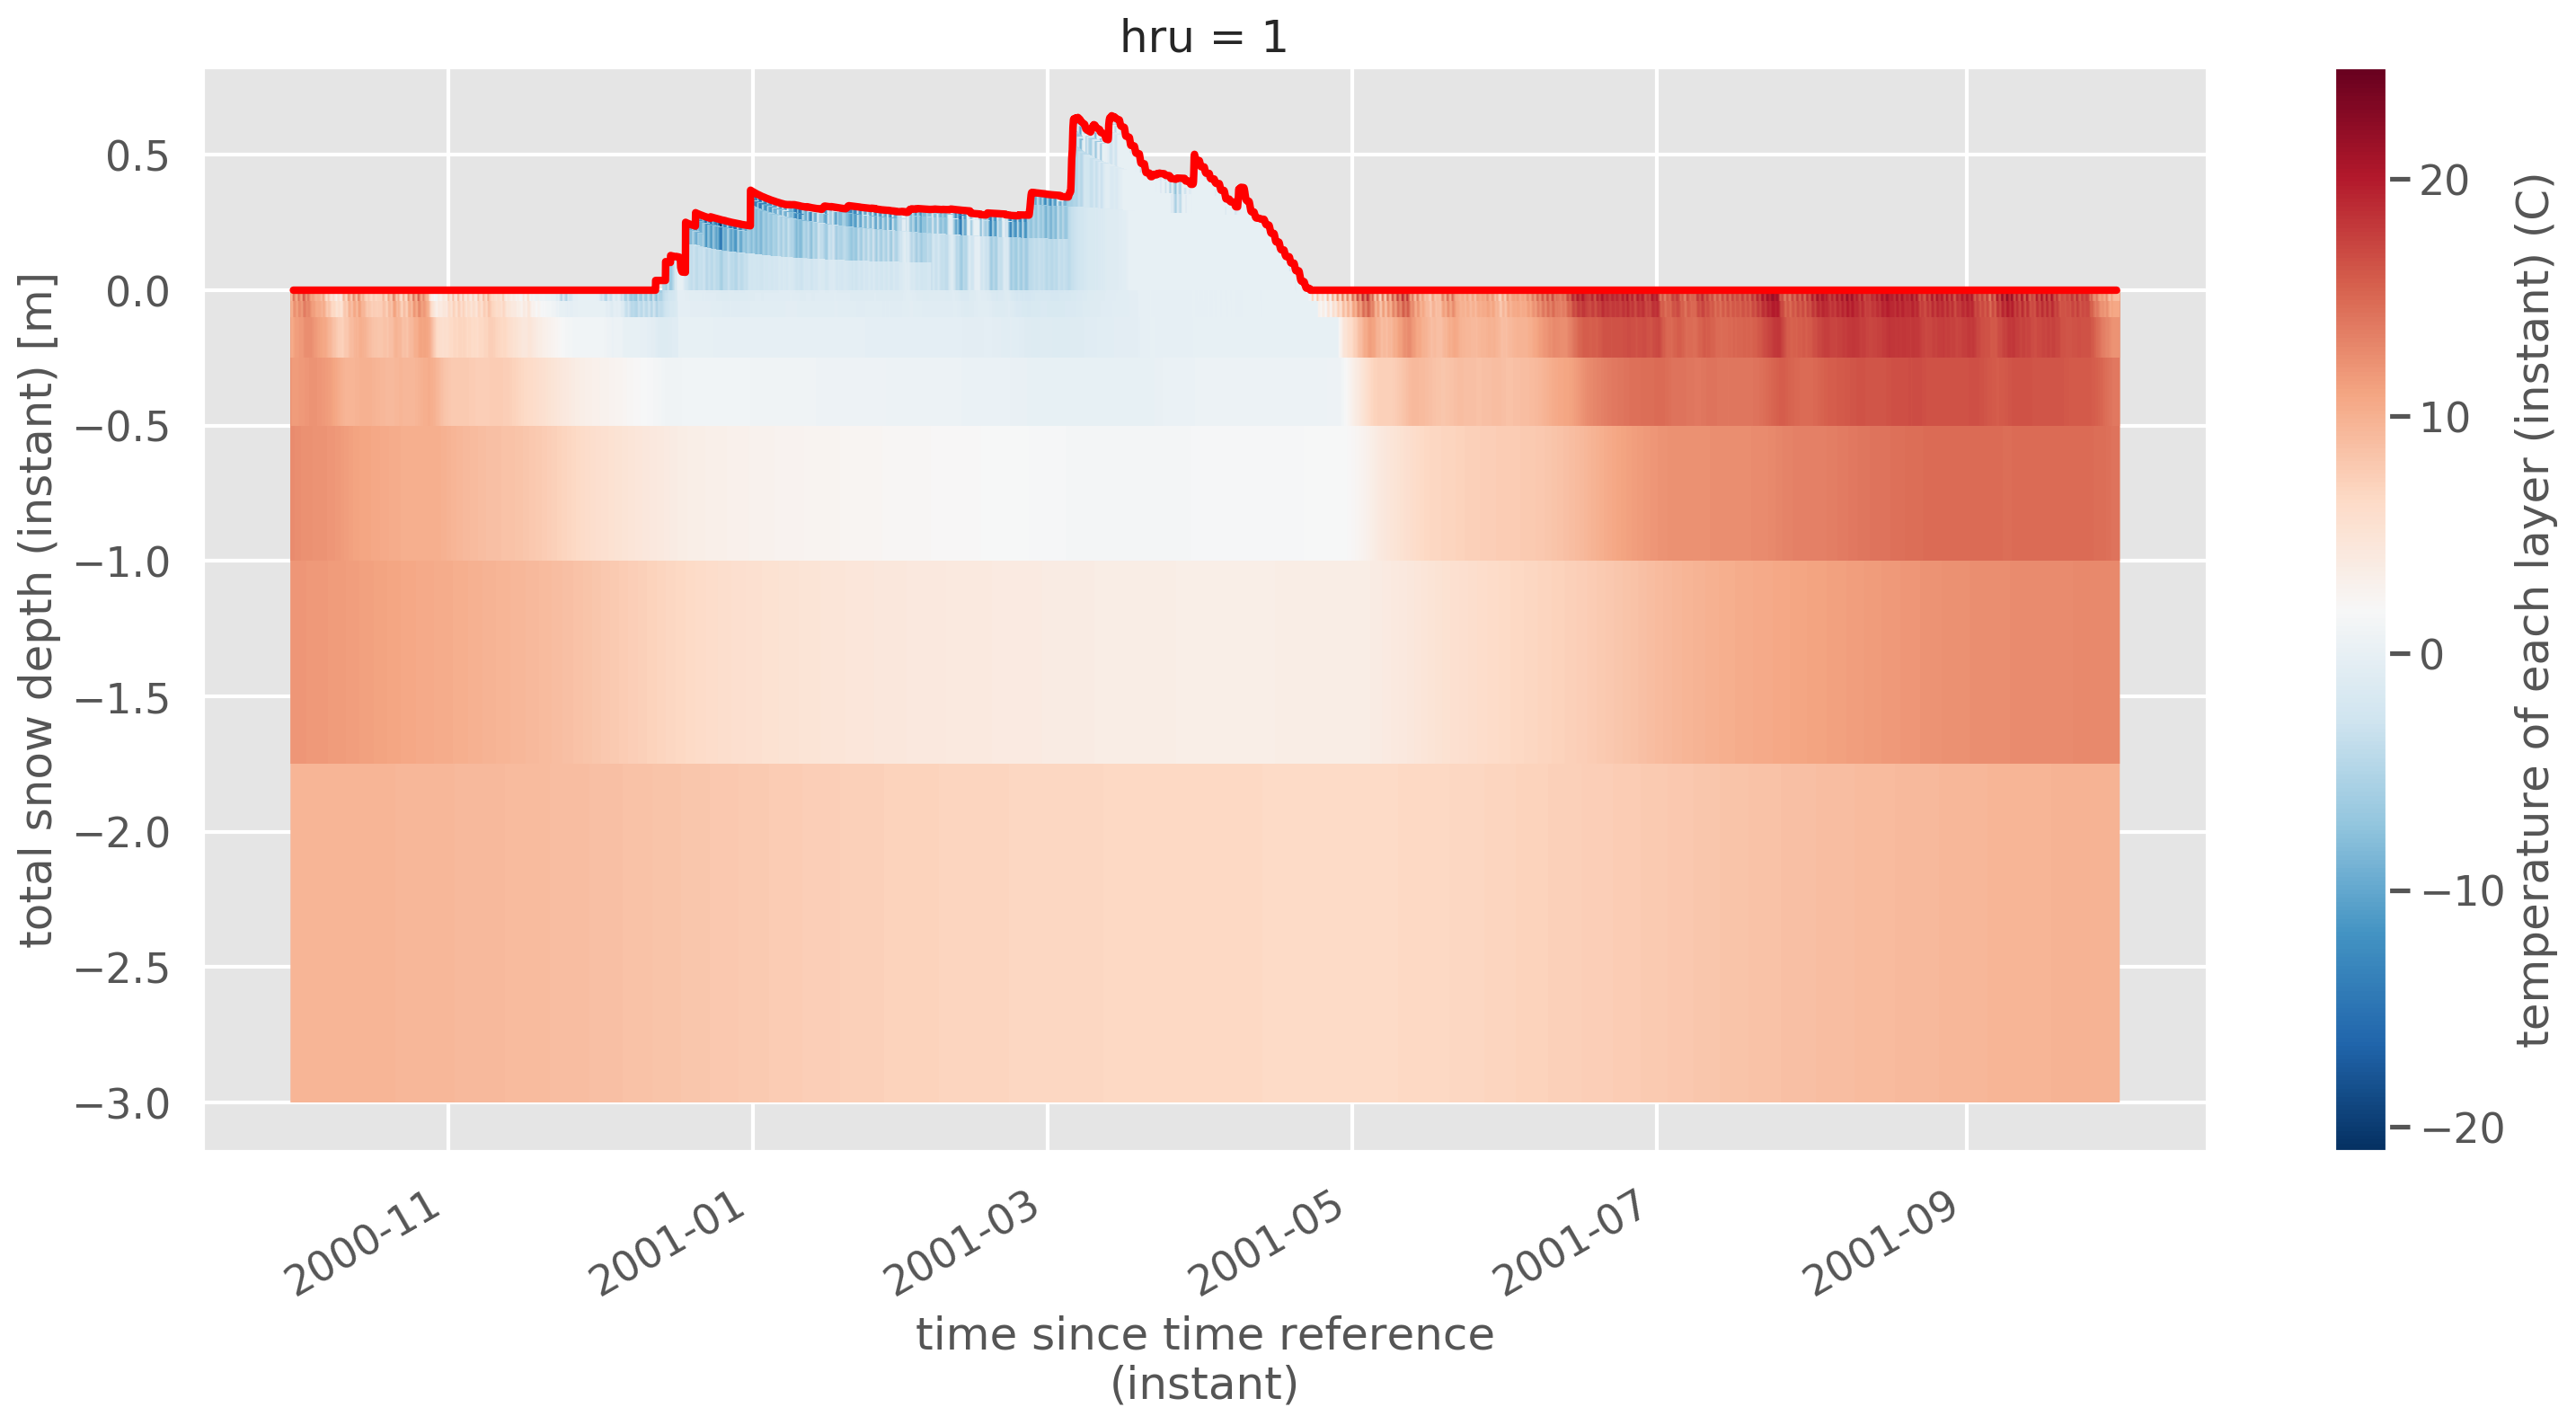

In [12]:
ax = plot_layers(var, depth, colormap='RdBu_r')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

The white area now represents the zero isotherm.

## 2D plot of snowpack and soil water with time

We can also plot the total water content and change the color bar:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


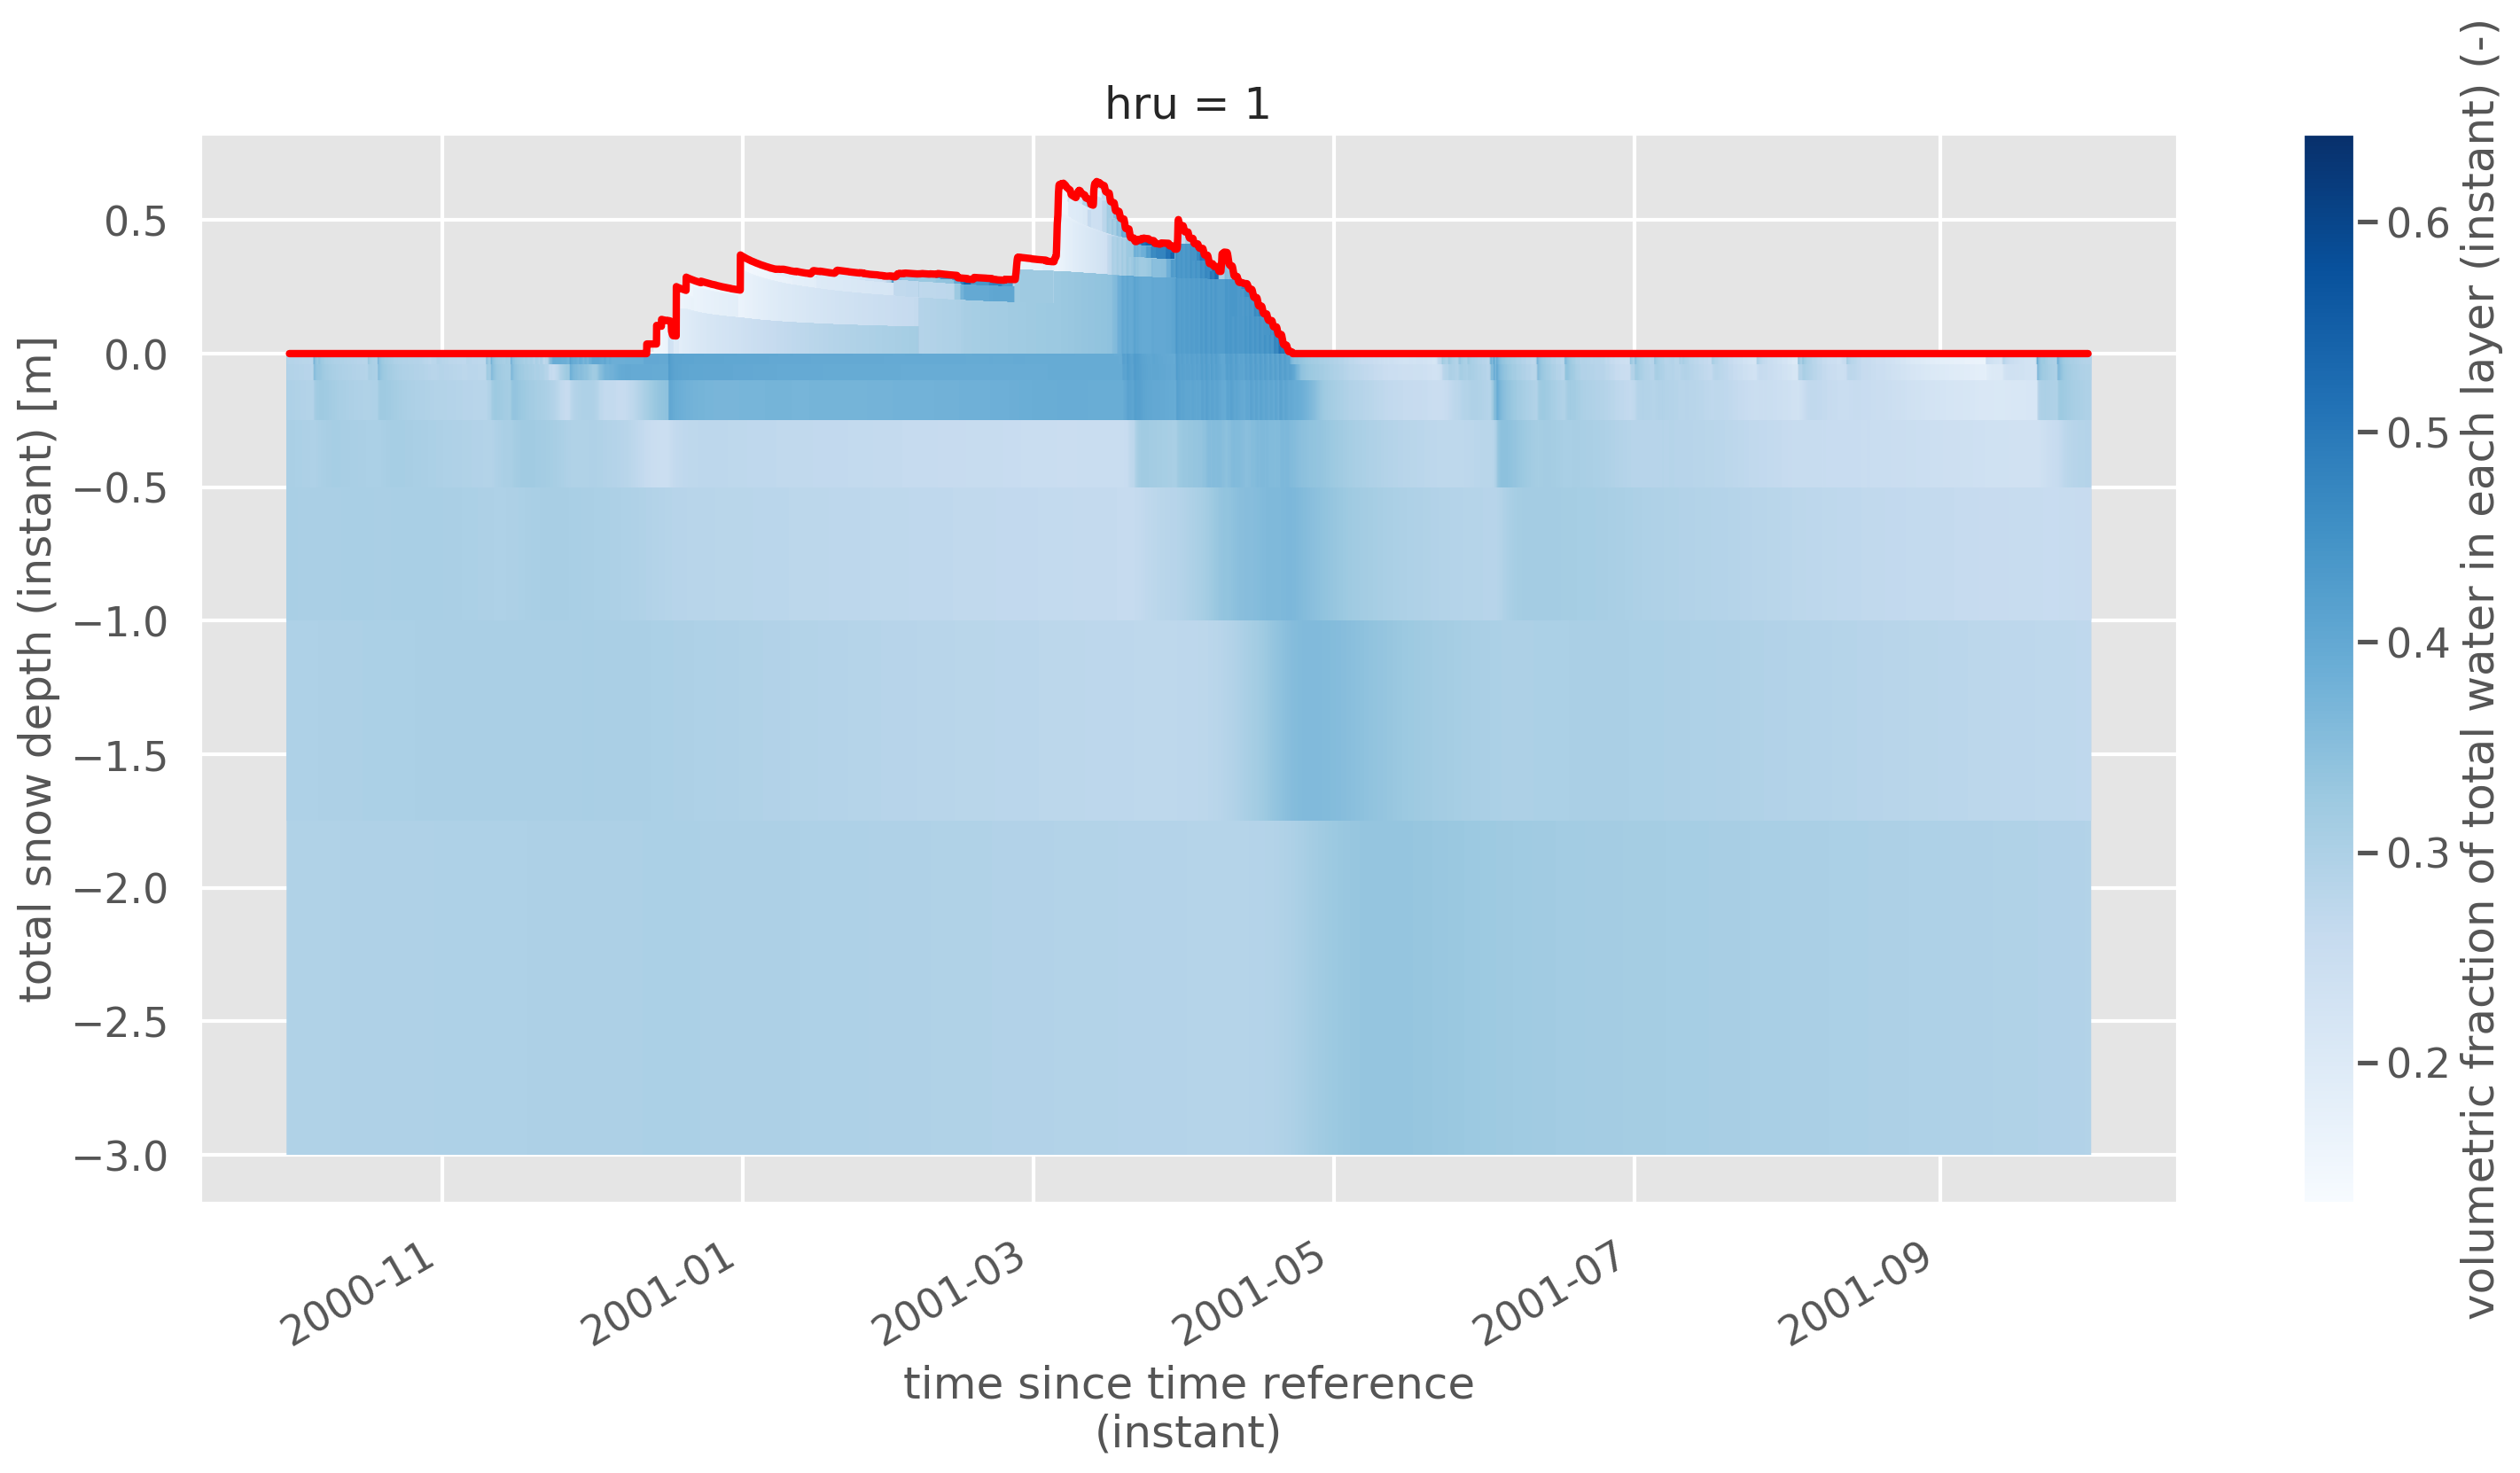

In [13]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerVolFracWat
ax = plot_layers(var, depth, colormap='Blues')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

You can see how the snow gets denser during the melt period (more water per layer) and how the melt plume moves into the soil.

This total water content includes both liquid water and ice (frozen water). We can plot just the amount of liquid water

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


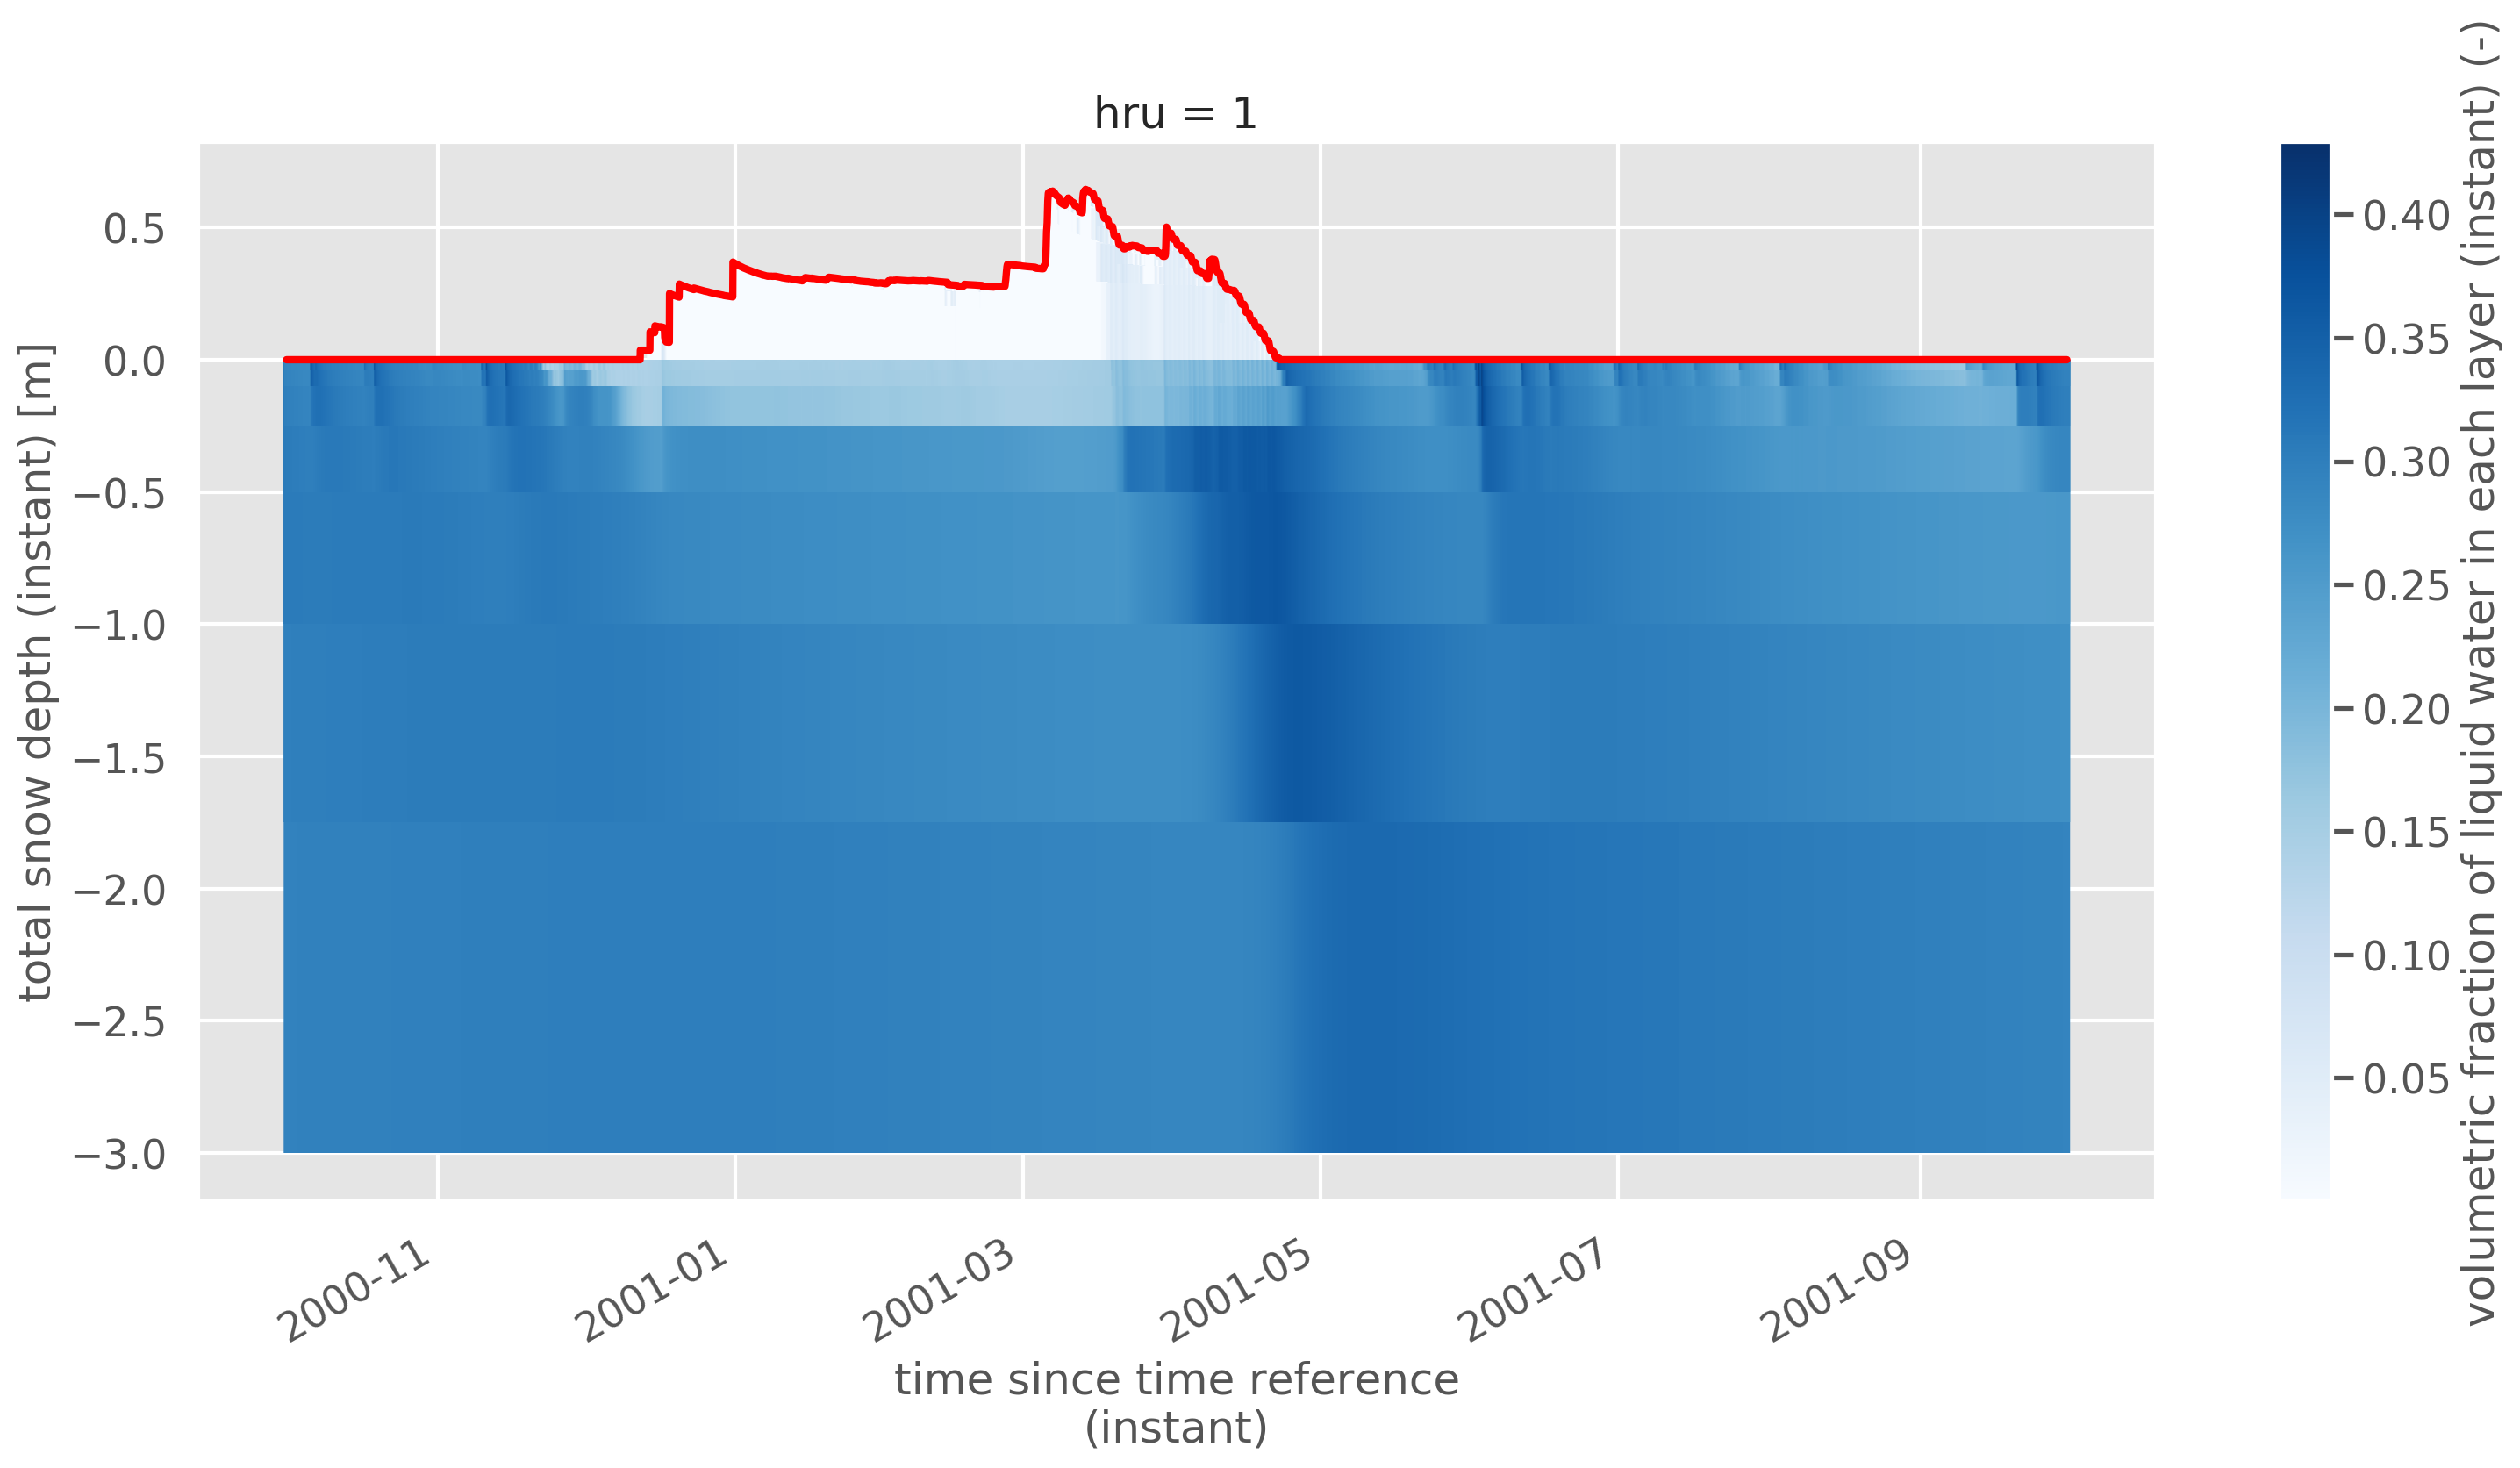

In [14]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerVolFracLiq
ax = plot_layers(var, depth, colormap='Blues')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

As you can see, the liquid water content in the snow pack is really low, but increases once the snow starts melting. We can also plot the ice content separately:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


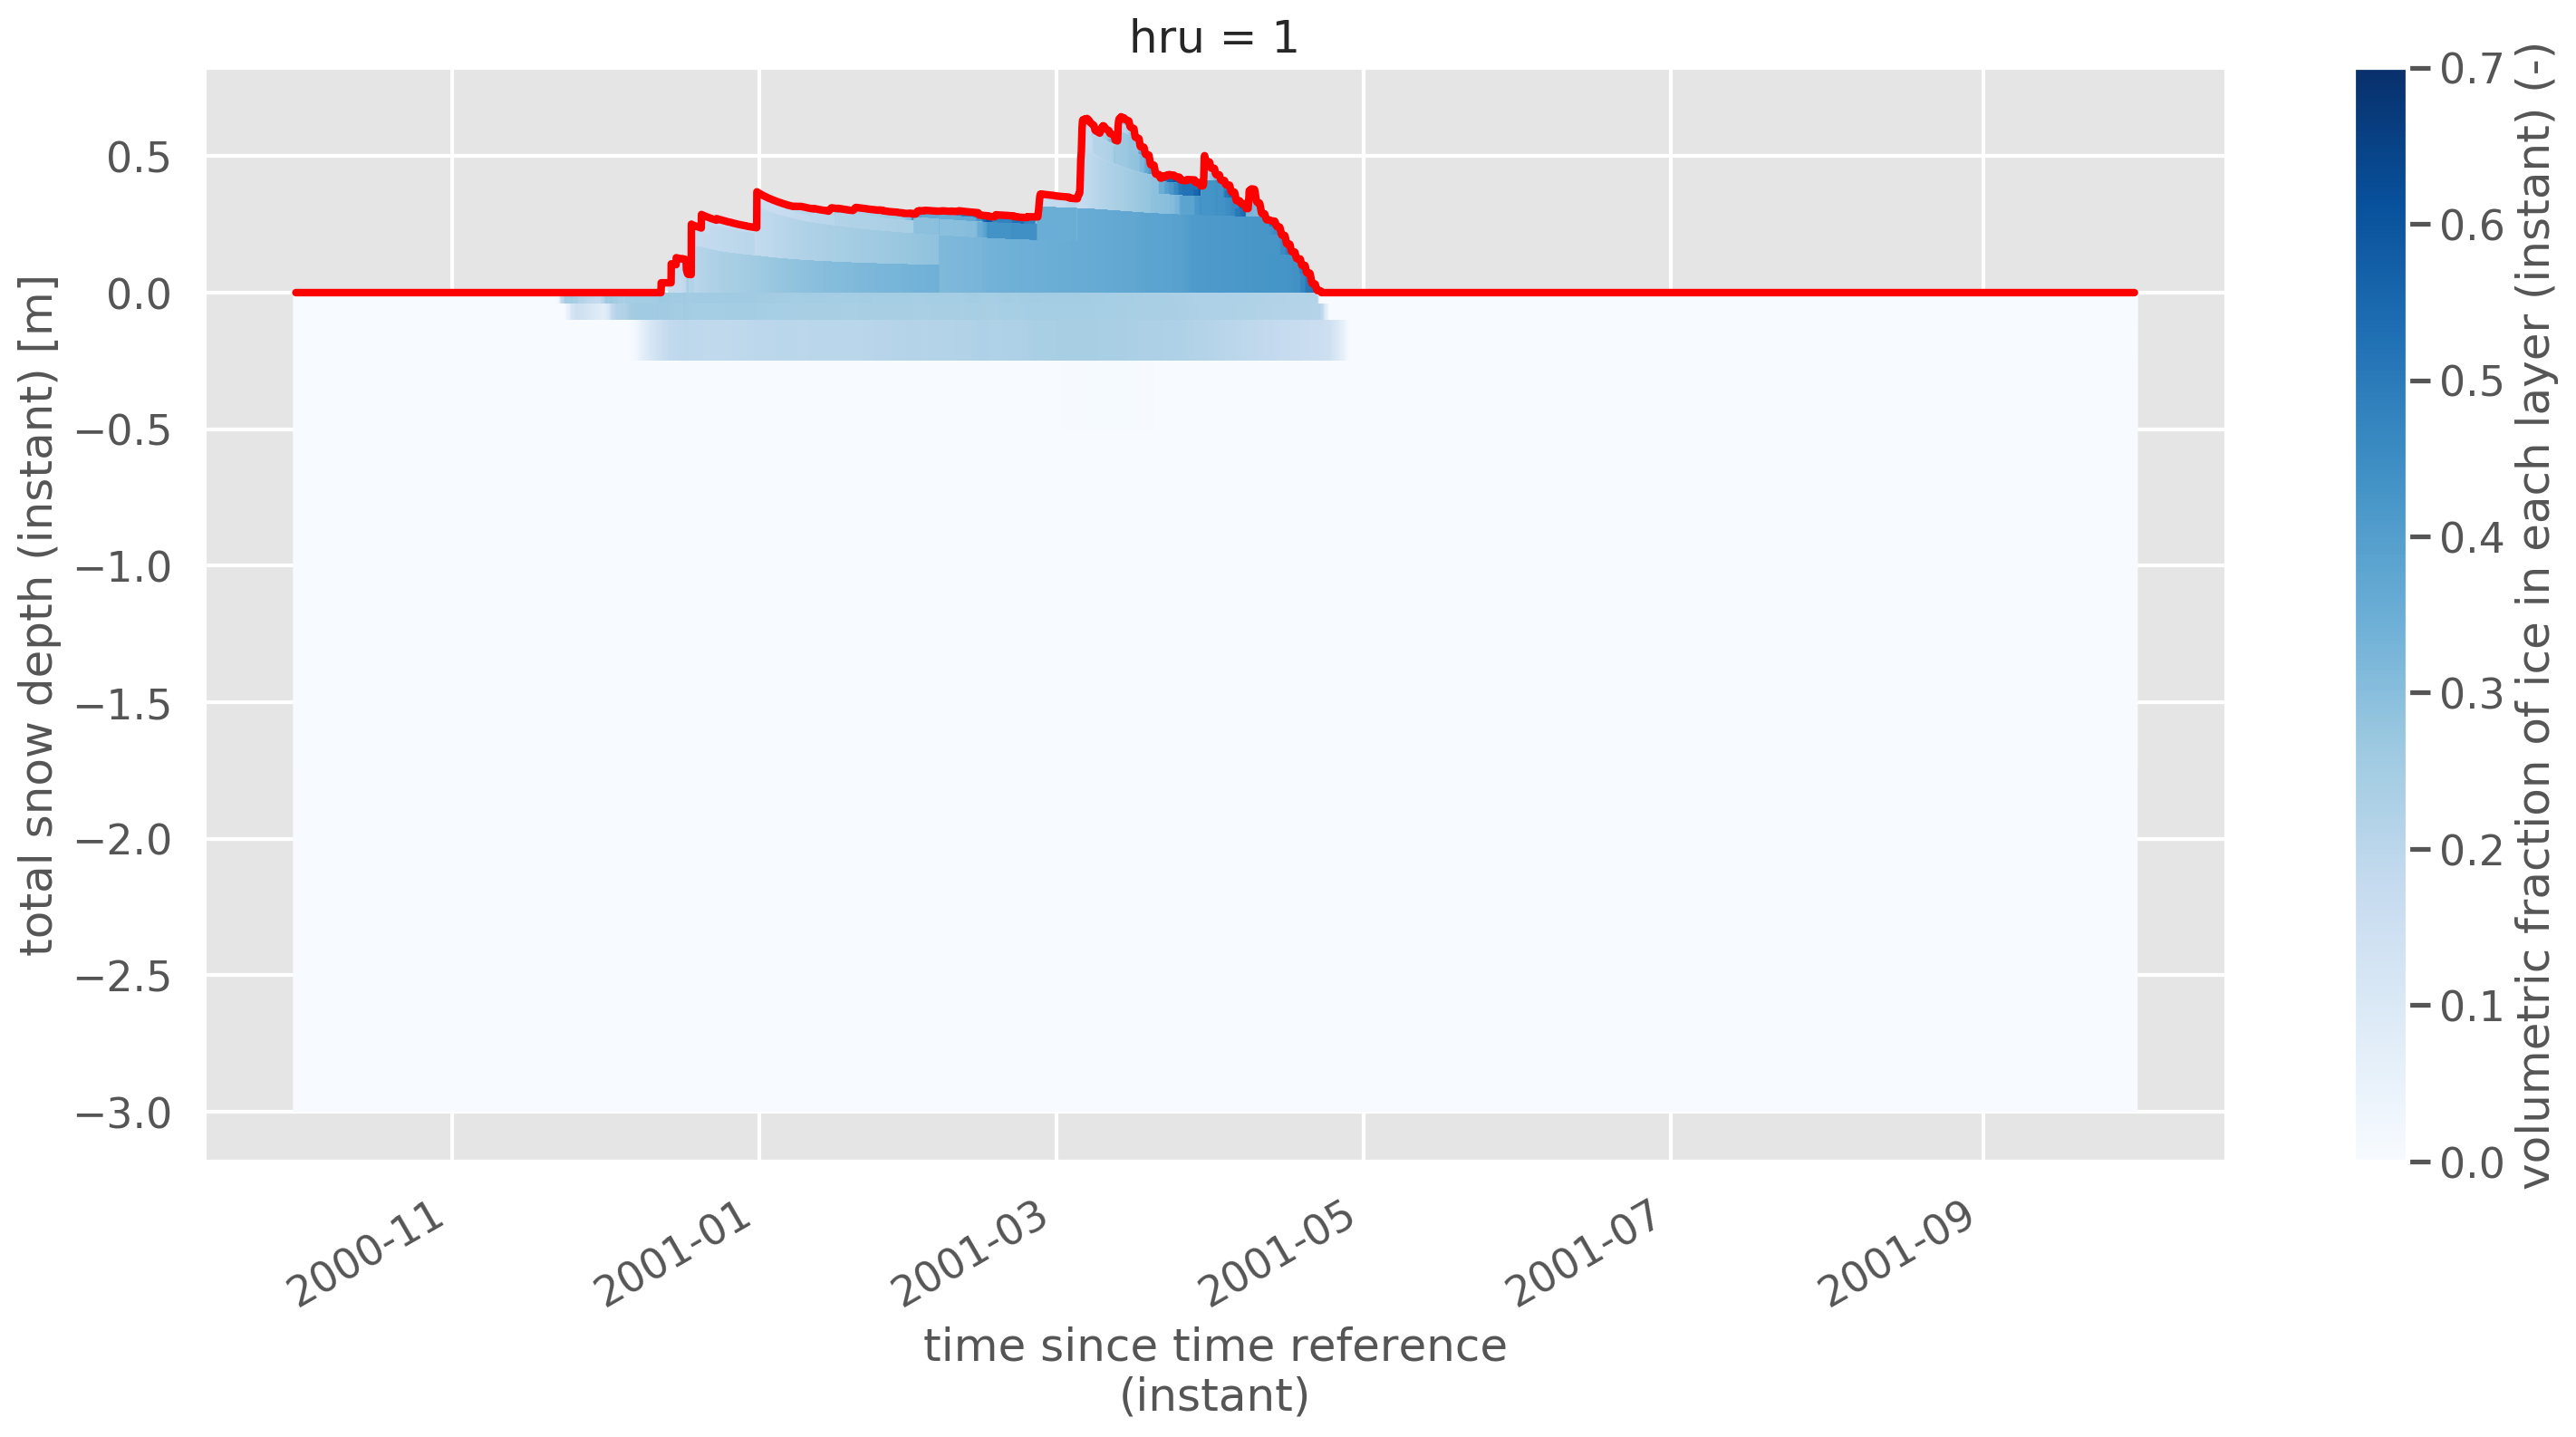

In [15]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerVolFracIce
ax = plot_layers(var, depth, colormap='Blues')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

Not surprisingly, the water in the snow pack is mostly frozen as is a thin layer below the snow, which thaws quickly when the snow melts.

You'll have to do some more manipulation if you want to plot the snow pack or the soil layers only. For example, if you want the soil layers without the snow pack, you need to select for `depth>=0`. To get the right colorbar, you also need to select the right `mLayerVolFracLiq` values that refer to the soil and remember that `mLayerVolFraqLiq` varies along `mLayerHeight`. 

So if we only want to look at the liquid water in the soil:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


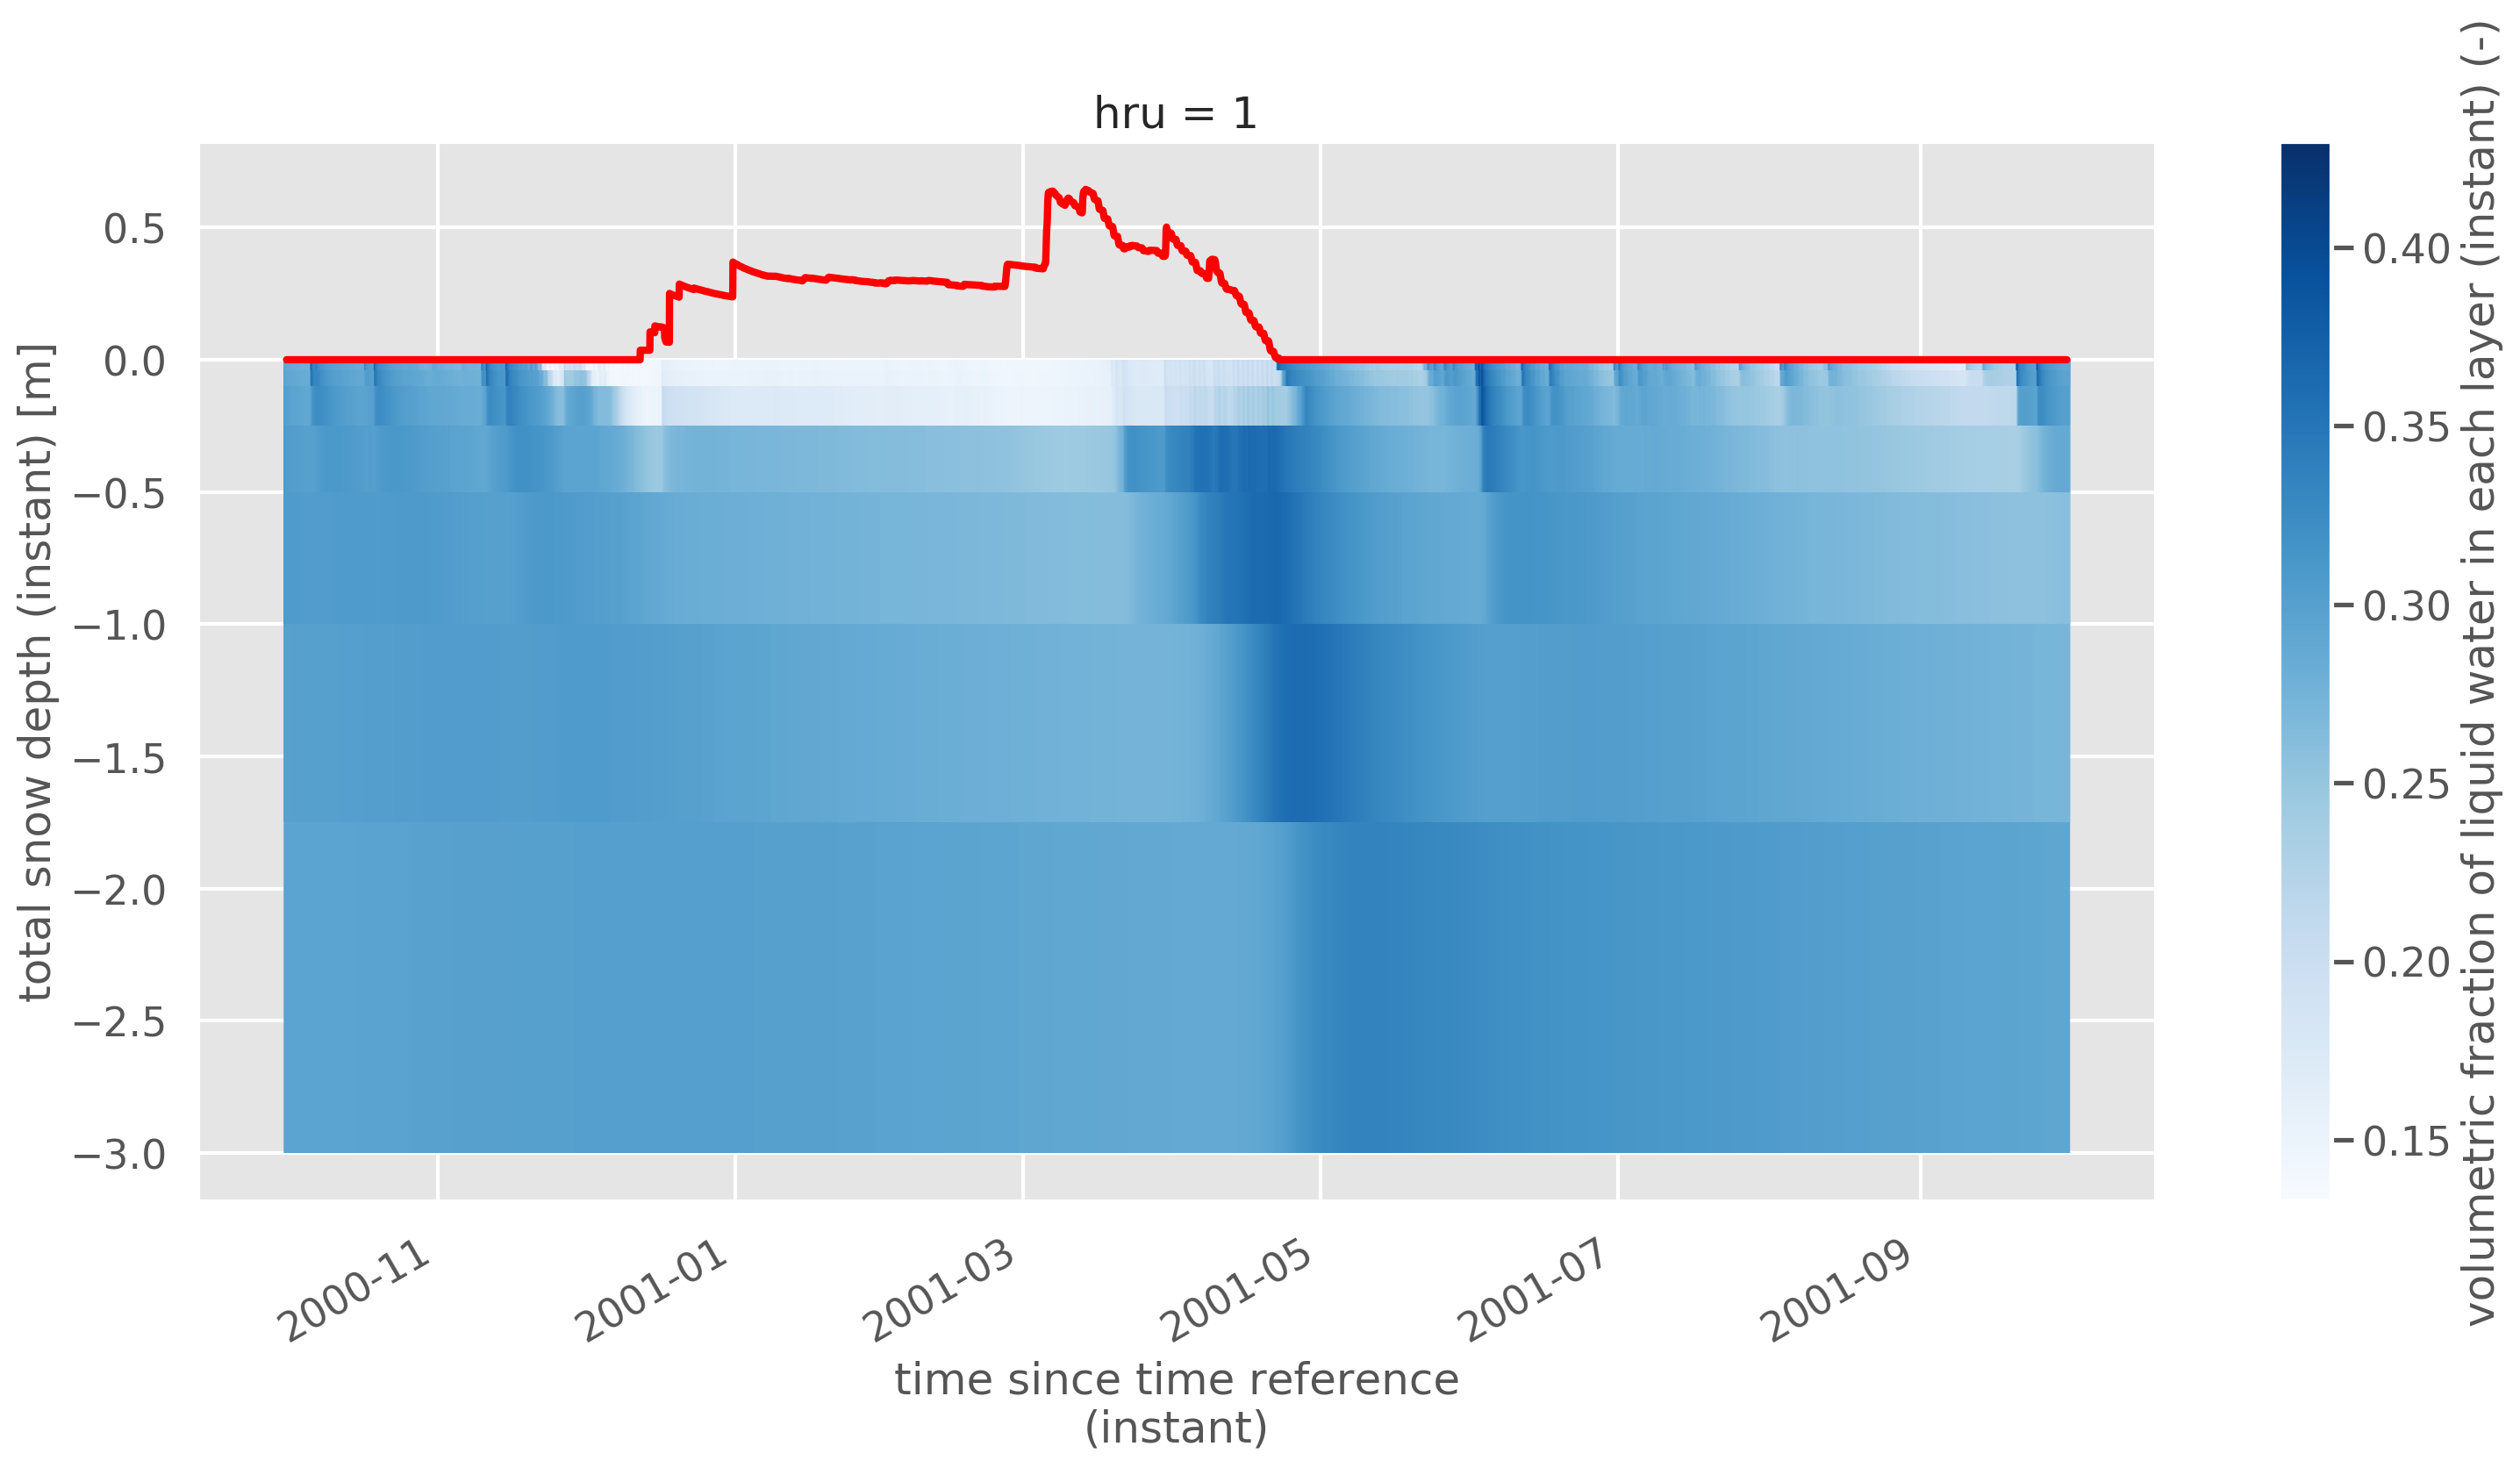

In [16]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
depth_soil_only = depth.where(depth>=0)

mdepth = S.output.sel(time=slice(start, end), hru=1).mLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerVolFracLiq
var_soil_only = var.where(mdepth>=0)

ax = plot_layers(var_soil_only, depth_soil_only, colormap='Blues')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

and if we want to only look at the liquid water in the snow pack:

/srv/conda/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


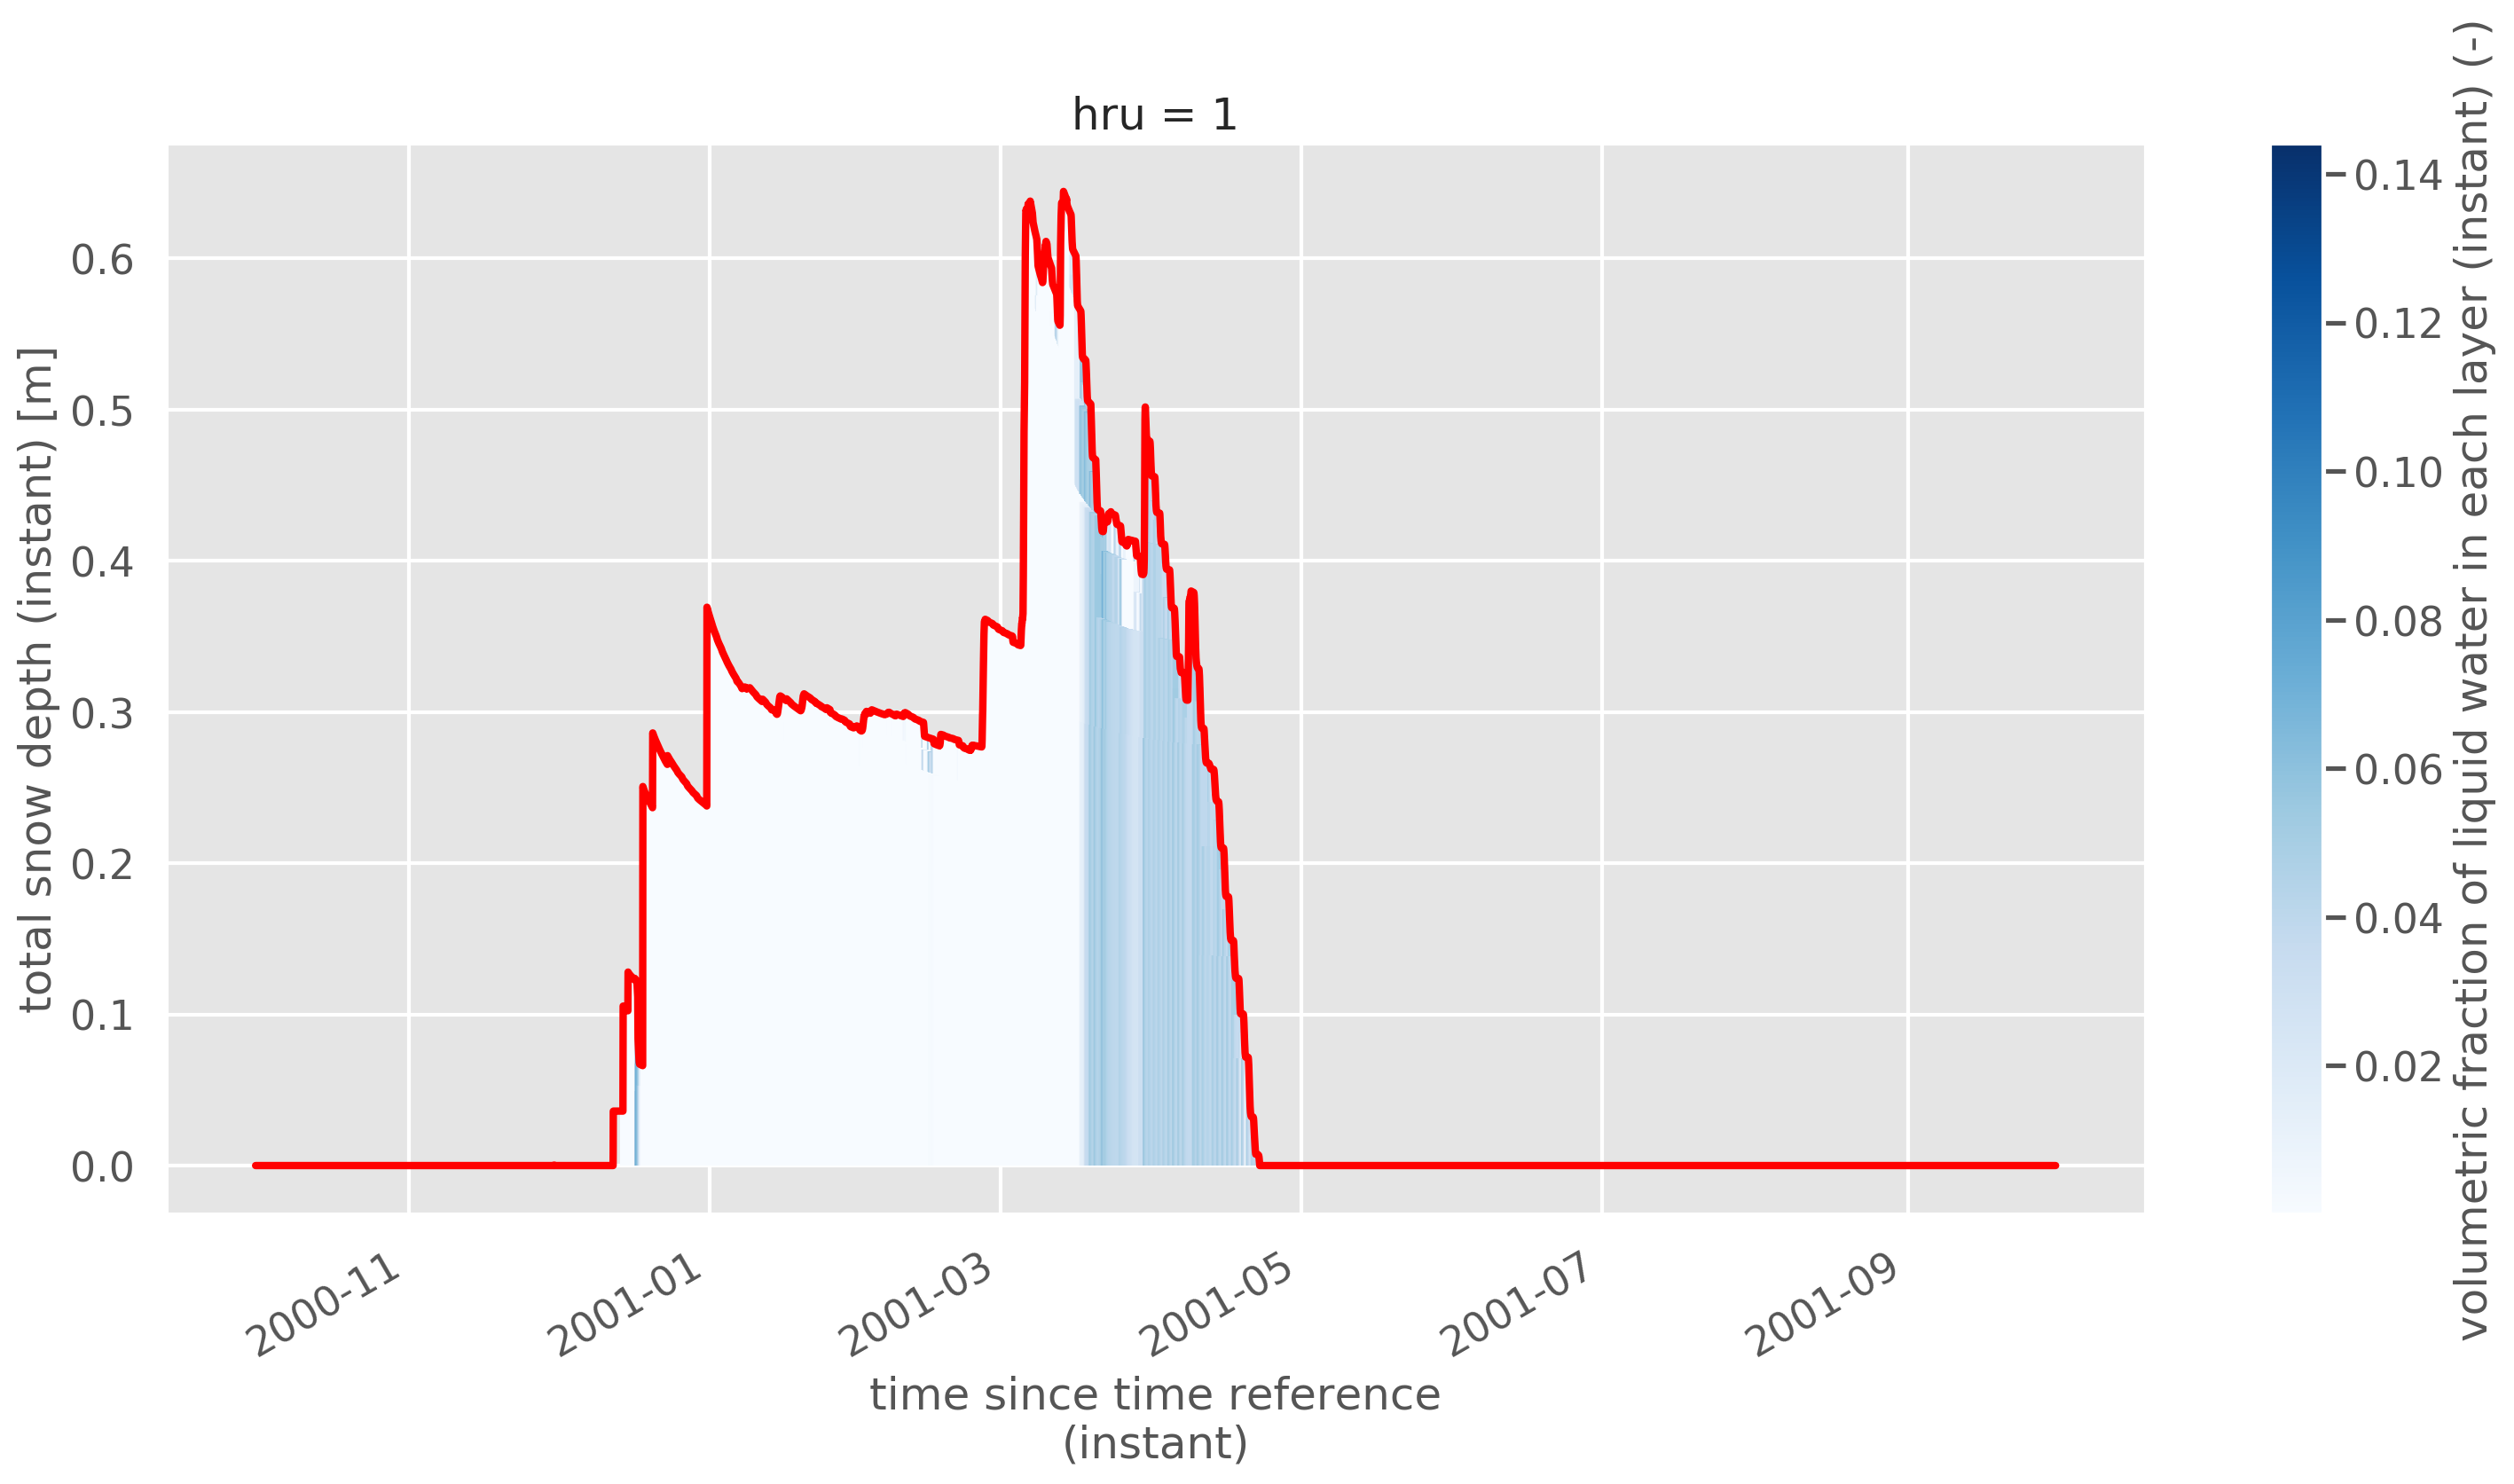

In [17]:
depth = S.output.sel(time=slice(start, end), hru=1).iLayerHeight
depth_snow_only = depth.where(depth<=0)

mdepth = S.output.sel(time=slice(start, end), hru=1).mLayerHeight
var = S.output.sel(time=slice(start, end), hru=1).mLayerVolFracLiq
var_snow_only = var.where(mdepth<=0)

ax = plot_layers(var_snow_only, depth_snow_only, colormap='Blues')
S.output.scalarSnowDepth.sel(time=slice(start, end), hru=1).plot(color='red',linewidth=3, ax=ax)

Note the small amounts of liquid water in the snow pack during mid-season melt events.